# RNN for Key Sequence from Scratch

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import random
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Create the Dataset

In [2]:
# Generate Key Sequences with two patterns
keyboard_keys = ['Q', 'W', 'E', 'R', 'T', 'Y']
key_sequences = []

for i in range(100):
    pattern_type = i % 2  # Define 2 types of patterns
    sequence = []
    if pattern_type == 0:  # Alternating pattern
        sequence = [keyboard_keys[j % len(keyboard_keys)] for j in range(100)]
    elif pattern_type == 1:  # Gradual shifts
        start_index = random.randint(0, len(keyboard_keys) - 1)
        sequence = [keyboard_keys[(start_index + j) % len(keyboard_keys)] for j in range(100)]
    key_sequences.append(sequence)

# Create DataFrames
key_df = pd.DataFrame(key_sequences).add_prefix("Key_Sequences_")

# Save to CSV
key_df.to_csv("Patterned_Key_Sequences.csv", index=False)
print("Datasets saved as 'Key_Sequences.csv'.")

Datasets saved as 'Key_Sequences.csv'.


### Load the datasets

In [3]:
key_sequences_file = "Patterned_Key_Sequences.csv"
key_df = pd.read_csv(key_sequences_file)
key_df.shape

(100, 100)

In [4]:
key_df.head(5)

,Key_Sequences_0,Key_Sequences_1,Key_Sequences_2,Key_Sequences_3,Key_Sequences_4,Key_Sequences_5,Key_Sequences_6,Key_Sequences_7,Key_Sequences_8,Key_Sequences_9,...,Key_Sequences_90,Key_Sequences_91,Key_Sequences_92,Key_Sequences_93,Key_Sequences_94,Key_Sequences_95,Key_Sequences_96,Key_Sequences_97,Key_Sequences_98,Key_Sequences_99
0,Q,W,E,R,T,Y,Q,W,E,R,...,Q,W,E,R,T,Y,Q,W,E,R
1,E,R,T,Y,Q,W,E,R,T,Y,...,E,R,T,Y,Q,W,E,R,T,Y
2,Q,W,E,R,T,Y,Q,W,E,R,...,Q,W,E,R,T,Y,Q,W,E,R
3,E,R,T,Y,Q,W,E,R,T,Y,...,E,R,T,Y,Q,W,E,R,T,Y
4,Q,W,E,R,T,Y,Q,W,E,R,...,Q,W,E,R,T,Y,Q,W,E,R


### Preprocess the datasets

In [5]:
inputs = np.array(key_df)
inputs.shape

def string_to_one_hot(inputs: np.ndarray) -> np.ndarray:
    char_to_index = {char: i for i, char in enumerate(string.ascii_uppercase)}

    one_hot_inputs = []
    for row in inputs:
        one_hot_list = []
        for char in row:
            if char.upper() in char_to_index:
                one_hot_vector = np.zeros((len(string.ascii_uppercase), 1))
                one_hot_vector[char_to_index[char.upper()]] = 1
                one_hot_list.append(one_hot_vector)
        one_hot_inputs.append(one_hot_list)

    return np.array(one_hot_inputs)
one_hot_inputs = string_to_one_hot(inputs)
np.array(one_hot_inputs).shape

(100, 100, 26, 1)

## Key Sequence RNN Implementation

### Input Layer

In [6]:
class InputLayer:
    inputs: np.ndarray
    U: np.ndarray = None
    delta_U: np.ndarray = None

    def __init__(self, inputs: np.ndarray, hidden_size: int) -> None:
        self.inputs = inputs

        # Xavier Initialization (replace with He initialization if using ReLU)
        self.U = np.random.randn(hidden_size, len(inputs[0])) * np.sqrt(1 / len(inputs[0]))

        self.delta_U = np.zeros_like(self.U)

    def get_input(self, time_step: int) -> np.ndarray:
        return self.inputs[time_step]

    def weighted_sum(self, time_step: int) -> np.ndarray:
        return self.U @ self.get_input(time_step)

    def calculate_deltas_per_step(
        self, time_step: int, delta_weighted_sum: np.ndarray
    ) -> None:
        # Update delta_U and apply gradient clipping
        self.delta_U += delta_weighted_sum @ self.get_input(time_step).T
        max_norm = 1.0  # Clip gradient to this norm
        grad_norm = np.linalg.norm(self.delta_U)
        if grad_norm > max_norm:
            self.delta_U *= max_norm / grad_norm

    def update_weights_and_bias(self, learning_rate: float) -> None:
        self.U -= learning_rate * self.delta_U
        self.delta_U = np.zeros_like(self.U)  # Reset gradients

### Hidden Layer

In [7]:
class HiddenLayer:
    def __init__(self, sequence_length: int, size: int, dropout_rate: float = 0.0) -> None:
        # Improved weight initialization
        self.W = np.random.randn(size, size) * np.sqrt(1 / size)  # Xavier Initialization
        self.bias = np.zeros((size, 1))  # Initialize biases to 0
        self.states = np.zeros(shape=(sequence_length, size, 1))
        self.next_delta_activation = np.zeros((size, 1))  # Initialize for backpropagation
        self.delta_bias = np.zeros_like(self.bias)
        self.delta_W = np.zeros_like(self.W)
        self.dropout_rate = dropout_rate

    def get_hidden_state(self, time_step: int) -> np.ndarray:
        if time_step < 0:
            return np.zeros_like(self.states[0])
        return self.states[time_step]

    def set_hidden_state(self, time_step: int, hidden_state: np.ndarray) -> None:
        self.states[time_step] = hidden_state

    def activate(self, weighted_input: np.ndarray, time_step: int, training: bool = True) -> np.ndarray:
        previous_hidden_state = self.get_hidden_state(time_step - 1)
        weighted_sum = weighted_input + self.W @ previous_hidden_state + self.bias
        activation = np.tanh(weighted_sum)  # Use ReLU if needed: np.maximum(0, weighted_sum)

        # Apply dropout during training
        if self.dropout_rate > 0 and training:
            dropout_mask = np.random.binomial(1, 1 - self.dropout_rate, activation.shape)
            activation *= dropout_mask
        self.set_hidden_state(time_step, activation)
        return activation

    def calculate_deltas_per_step(self, time_step: int, delta_output: np.ndarray) -> np.ndarray:
        # Compute delta activation
        delta_activation = delta_output + self.next_delta_activation
        delta_weighted_sum = delta_activation * (1 - self.get_hidden_state(time_step) ** 2)

        # Gradient clipping to avoid exploding gradients
        max_norm = 1.0  # Threshold for clipping
        grad_norm = np.linalg.norm(delta_weighted_sum)
        if grad_norm > max_norm:
            delta_weighted_sum *= max_norm / grad_norm

        # Compute weight and bias deltas
        self.next_delta_activation = self.W.T @ delta_weighted_sum
        self.delta_W += delta_weighted_sum @ self.get_hidden_state(time_step - 1).T
        self.delta_bias += delta_weighted_sum
        return delta_weighted_sum

    def update_weights_and_bias(self, learning_rate: float) -> None:
        self.W -= learning_rate * self.delta_W
        self.bias -= learning_rate * self.delta_bias

        # Reset deltas after update
        self.delta_W = np.zeros_like(self.W)
        self.delta_bias = np.zeros_like(self.bias)

### Output Layer

In [8]:
class OutputLayer:
    def __init__(self, size: int, hidden_size: int, sequence_length: int) -> None:
        # Improved weight initialization
        self.V = np.random.randn(size, hidden_size) * np.sqrt(1 / hidden_size)  # Xavier Initialization
        self.bias = np.zeros((size, 1))  # Initialize biases to 0
        self.states = np.zeros(shape=(sequence_length, size, 1))  # Match the time steps
        self.delta_bias = np.zeros_like(self.bias)  # Gradient accumulator for biases
        self.delta_V = np.zeros_like(self.V)  # Gradient accumulator for weights

    @staticmethod
    def softmax(x: np.ndarray) -> np.ndarray:
        exp_x = np.exp(x - np.max(x))  # Stability fix to avoid overflow
        return exp_x / (np.sum(exp_x, axis=0, keepdims=True) + 1e-8)  # Add epsilon for stability

    def predict(self, hidden_state: np.ndarray, time_step: int) -> np.ndarray:
        output = self.V @ hidden_state + self.bias  # Compute logits
        prediction = self.softmax(output)  # Apply softmax
        self.set_state(time_step, prediction)  # Save prediction state
        return prediction

    def get_state(self, time_step: int) -> np.ndarray:
        return self.states[time_step]

    def set_state(self, time_step: int, prediction: np.ndarray) -> None:
        if time_step >= len(self.states):
            print(f"Warning: Time step {time_step} exceeds sequence length {len(self.states)}.")
            return
        self.states[time_step] = prediction

    def calculate_deltas_per_step(
        self,
        expected: np.ndarray,
        hidden_state: np.ndarray,
        time_step: int,
    ) -> np.ndarray:
        delta_output = self.get_state(time_step) - expected  # Error at the output layer

        # Accumulate gradients for weights and biases
        self.delta_V += delta_output @ hidden_state.T
        self.delta_bias += delta_output

        # Return the gradient of the loss with respect to the hidden state
        return self.V.T @ delta_output

    def update_weights_and_bias(self, learning_rate: float, clip_value: float = 5.0) -> None:
        # Apply gradient clipping
        if np.linalg.norm(self.delta_V) > clip_value:
            #print("Clipping gradient for V")
            pass
        if np.linalg.norm(self.delta_bias) > clip_value:
            #print("Clipping gradient for bias")
            pass

        np.clip(self.delta_V, -clip_value, clip_value, out=self.delta_V)
        np.clip(self.delta_bias, -clip_value, clip_value, out=self.delta_bias)

        # Update weights and reset deltas
        self.V -= learning_rate * self.delta_V
        self.bias -= learning_rate * self.delta_bias
        self.delta_V = np.zeros_like(self.V)
        self.delta_bias = np.zeros_like(self.bias)

### Key Sequence RNN Workflow

In [9]:
from typing import List, Union

class KeySequenceRNN:
    def __init__(
        self,
        vocab_size: int,
        hidden_size: Union[int, List[int]],
        alpha: float,
        sequence_length: int,
        num_layers: int = 1,
        dropout_rate: float = 0.0,
    ) -> None:
        # Validate hidden size and layers
        if num_layers <= 0:
            raise ValueError("num_layers must be greater than 0.")
        if isinstance(hidden_size, int):
            hidden_size = [hidden_size] * num_layers
        elif len(hidden_size) != num_layers:
            raise ValueError("Length of hidden_size must match num_layers if hidden_size is a list")
        if any(s <= 0 for s in hidden_size):
            raise ValueError("All hidden sizes must be positive.")

        self.hidden_layers = [
            HiddenLayer(sequence_length=sequence_length, size=size, dropout_rate=dropout_rate)
            for size in hidden_size
        ]
        self.output_layer = OutputLayer(size=vocab_size, hidden_size=hidden_size[-1], sequence_length=sequence_length)
        self.hidden_size = hidden_size
        self.alpha = alpha

    def feed_forward(self, inputs: np.ndarray, training: bool = True) -> OutputLayer:
        self.input_layer = InputLayer(inputs, self.hidden_size[0])
        activation = None

        for step in range(len(inputs)):
            # Pass through the input and hidden layers
            weighted_input = self.input_layer.weighted_sum(step)
            activation = self.hidden_layers[0].activate(weighted_input, step, training)

            for layer_idx in range(1, len(self.hidden_layers)):
                activation = self.hidden_layers[layer_idx].activate(activation, step, training)

            # Pass to the output layer
            self.output_layer.predict(activation, step)
        return self.output_layer
    
    def backpropagation(self, expected: np.ndarray) -> None:
        for step_number in reversed(range(len(expected))):
            # Output layer backward pass
            delta_output = self.output_layer.calculate_deltas_per_step(
                expected[step_number],
                self.hidden_layers[-1].get_hidden_state(step_number),  # Use the last hidden layer's state
                step_number,
            )

            # Backpropagate through hidden layers
            delta_hidden = delta_output
            for layer_idx in reversed(range(len(self.hidden_layers))):
                delta_hidden = self.hidden_layers[layer_idx].calculate_deltas_per_step(
                    step_number, delta_hidden
                )

            # Input layer backward pass (only connects to the first hidden layer)
            self.input_layer.calculate_deltas_per_step(step_number, delta_hidden)

        # Update weights and biases
        self.output_layer.update_weights_and_bias(self.alpha)
        for layer in self.hidden_layers:
            layer.update_weights_and_bias(self.alpha)
        self.input_layer.update_weights_and_bias(self.alpha)

    def validate_input_shapes(self, inputs: np.ndarray, expected: np.ndarray) -> None:
        if len(inputs) != len(expected):
            raise ValueError("The number of input sequences must match the number of expected outputs.")

    def train(self, inputs: np.ndarray, expected: np.ndarray, epochs: int, validation_data=None) -> tuple:
        self.validate_input_shapes(inputs, expected)
        training_losses = []
        validation_losses = []

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            epoch_loss = 0

            for idx, input_seq in enumerate(inputs):
                y_hats = self.feed_forward(input_seq, training=True)
                self.backpropagation(expected[idx])
                loss = self.loss([y for y in y_hats.states], expected[idx])
                if np.isnan(loss):
                    raise ValueError(f"NaN encountered in loss at epoch {epoch}, sequence {idx}.")
                epoch_loss += loss
                #print(f"Loss for sequence {idx}: {loss}")

            avg_train_loss = epoch_loss / len(inputs)
            training_losses.append(avg_train_loss)

            # Validation step
            if validation_data is not None:
                val_loss = self.evaluate(validation_data, validation_data)
                validation_losses.append(val_loss)
                print(f"Validation Loss: {val_loss}")

        return training_losses, validation_losses

    def evaluate(self, inputs: np.ndarray, expected: np.ndarray) -> float:
        self.validate_input_shapes(inputs, expected)
        total_loss = 0
        for idx, input_seq in enumerate(inputs):
            y_hats = self.feed_forward(input_seq, training=False)
            total_loss += self.loss([y for y in y_hats.states], expected[idx])
        return total_loss / len(inputs)

    def loss(self, y_hat: List[np.ndarray], y: List[np.ndarray]) -> float:
        epsilon = 1e-8
        clipped_y_hat = [np.clip(y_pred, epsilon, 1 - epsilon) for y_pred in y_hat]
        return sum(-np.sum(y_true * np.log(y_pred)) for y_true, y_pred in zip(y, clipped_y_hat))

### Split the Dataset

In [10]:
# Split into train, validation, and test sets
train_data, temp_data = train_test_split(one_hot_inputs, test_size=0.3, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.66, random_state=42)

print(f"Training Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {validation_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Training Data Shape: (70, 100, 26, 1)
Validation Data Shape: (10, 100, 26, 1)
Test Data Shape: (20, 100, 26, 1)


### Grid Search to Find Best Model

In [11]:
from itertools import product

param_grid = {
    "hidden_size": [128, 256],
    "num_layers": [1, 2],
    "learning_rate": [0.0001, 0.001],
    "sequence_length": [6, 20, 50],
    "dropout_rate": [0.1, 0.2],
}

# Initialize variables to store results
grid_search_results = []
total_combinations = len(list(product(*param_grid.values())))
num_trials = 2  # Number of trials per hyperparameter combination

# Variables to track the best model's losses
best_training_losses = None
best_validation_losses = None
best_model = None

# Perform grid search
for i, params in enumerate(product(*param_grid.values()), start=1):
    hyperparams = dict(zip(param_grid.keys(), params))
    print(f"Testing combination {i}/{total_combinations}: {hyperparams}")

    # Duplicate `hidden_size` for each layer
    hidden_size = [hyperparams["hidden_size"]] * hyperparams["num_layers"]

    # Apply sequence length (truncate data if necessary)
    seq_length = hyperparams["sequence_length"]
    max_length = train_data.shape[1]
    if seq_length > max_length:
        print(f"Skipping sequence length {seq_length} exceeding max length {max_length}")
        continue

    truncated_train_data = train_data[:, :seq_length, :, :]
    truncated_val_data = validation_data[:, :seq_length, :, :]

    all_training_losses = []
    all_validation_losses = []
    for trial in range(num_trials):
        print(f"    Trial {trial + 1}/{num_trials} for combination {i}/{total_combinations}")

        # Initialize RNN with current hyperparameters
        rnn = KeySequenceRNN(
            vocab_size=len(string.ascii_uppercase),
            hidden_size=hidden_size,
            alpha=hyperparams["learning_rate"],
            sequence_length=seq_length,
            num_layers=hyperparams["num_layers"],
            dropout_rate=hyperparams["dropout_rate"],
        )

        # Train the model and get training/validation losses
        try:
            training_losses, validation_losses = rnn.train(
                truncated_train_data,
                truncated_train_data,
                epochs=100,
                validation_data=truncated_val_data,
            )
            all_training_losses.append(training_losses)
            all_validation_losses.append(validation_losses)

        except Exception as e:
            print(f"Error encountered with hyperparameters: {hyperparams}, Trial {trial + 1}: {e}")
            continue

    if not all_validation_losses:
        print(f"No valid trials for hyperparameters: {hyperparams}")
        continue

    # Average losses across trials
    avg_training_loss = np.mean([np.mean(loss) for loss in all_training_losses])
    avg_validation_loss = np.mean([np.mean(loss) for loss in all_validation_losses])
    print(f"Hyperparameters: {hyperparams}, Avg Training Loss: {avg_training_loss}, Avg Validation Loss: {avg_validation_loss}")

    # Check if this combination is the best so far
    if best_validation_losses is None or avg_validation_loss < np.mean(best_validation_losses):
        best_training_losses = np.mean(all_training_losses, axis=0)  # Epoch-wise average across trials
        best_validation_losses = np.mean(all_validation_losses, axis=0)
        best_model = rnn  # Save the best model

    grid_search_results.append({
        "combination": i,
        "hyperparams": hyperparams,
        "avg_training_loss": avg_training_loss,
        "avg_validation_loss": avg_validation_loss,
    })

# Print validation results for each combination
print("\nValidation Results for All Combinations:")
for result in grid_search_results:
    print(f"Combination {result['combination']}/{total_combinations}:")
    print(f"  Params: {result['hyperparams']}")
    print(f"  Avg Training Loss: {result['avg_training_loss']}")
    print(f"  Avg Validation Loss: {result['avg_validation_loss']}\n")

# Find and print the best parameters
best_result = min(grid_search_results, key=lambda x: x["avg_validation_loss"])
print("Best Hyperparameters:")
print(f"  Params: {best_result['hyperparams']}")
print(f"  Avg Training Loss: {best_result['avg_training_loss']}")
print(f"  Avg Validation Loss: {best_result['avg_validation_loss']}")

Testing combination 1/48: {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.0001, 'sequence_length': 6, 'dropout_rate': 0.1}
    Trial 1/2 for combination 1/48
Epoch 1/100
Validation Loss: 19.651275483446383
Epoch 2/100
Validation Loss: 19.715145496299368
Epoch 3/100
Validation Loss: 19.57469162444411
Epoch 4/100
Validation Loss: 19.540621691447353
Epoch 5/100
Validation Loss: 19.13136178548237
Epoch 6/100
Validation Loss: 19.114120380170103
Epoch 7/100
Validation Loss: 19.379574355549664
Epoch 8/100
Validation Loss: 19.024534012487685
Epoch 9/100
Validation Loss: 19.005896503090575
Epoch 10/100
Validation Loss: 19.306545385262957
Epoch 11/100
Validation Loss: 19.03175542042302
Epoch 12/100
Validation Loss: 18.7339065588344
Epoch 13/100
Validation Loss: 18.466147866626937
Epoch 14/100
Validation Loss: 18.346717793774886
Epoch 15/100
Validation Loss: 18.079224454071998
Epoch 16/100
Validation Loss: 18.363792018688464
Epoch 17/100
Validation Loss: 18.047610583892077
Epoch 18/100
V

### Error Analysis of the Best Model

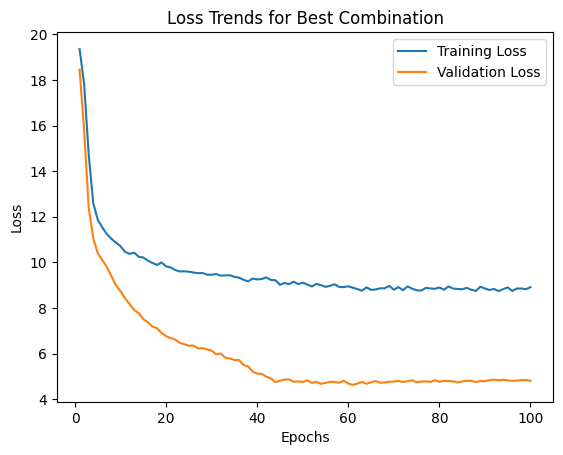

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation loss trends for the best model
if best_training_losses is not None and best_validation_losses is not None:
    epochs = range(1, len(best_training_losses) + 1)
    plt.plot(epochs, best_training_losses, label="Training Loss")
    plt.plot(epochs, best_validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Trends for Best Combination")
    plt.legend()
    plt.show()
else:
    print("No valid losses to plot.")

### Test the Best Model

In [13]:
# Test the best model with testing data
if best_model:
    best_seq_length = best_result['hyperparams']['sequence_length']
    truncated_test_data = test_data[:, :best_seq_length, :, :]
    test_loss = best_model.evaluate(truncated_test_data, truncated_test_data)
    print(f"Test Loss with Best Hyperparameters: {test_loss}")

Test Loss with Best Hyperparameters: 9.839501822616608


### Save the Best Model

In [14]:
import pickle

# Save the best model
if best_model:
    model_save_path = "rnn_model_for_key_sequence.pkl"
    with open(model_save_path, "wb") as f:
        pickle.dump(best_model, f)
    print(f"Best model saved to {model_save_path}")

Best model saved to rnn_model_for_key_sequence.pkl


### Load and Evaluate the Best Model

In [15]:
# Load and evaluate the saved model
with open("rnn_model_for_key_sequence.pkl", "rb") as f:
    best_rnn_model = pickle.load(f)
    loaded_test_loss = best_rnn_model.evaluate(truncated_test_data, truncated_test_data)
    print(f"Test Loss with Loaded Model: {loaded_test_loss}")

Test Loss with Loaded Model: 9.819947351757724
